In [1]:
import mrimotion as mot
import mghGErecon as ge
import importlib

from matplotlib import pyplot as plt
import numpy as np
import os
from scipy import ndimage

In [6]:
def simulate_multicoil_k(image, maps):
    """
    image: (x,y) (not-shifted)
    maps: (x,y,coils)
    """
    image = np.repeat(image[:, :, np.newaxis], maps.shape[2], axis=2)
    sens_image = image*maps
    shift_sens_image = np.fft.ifftshift(sens_image, axes=(0,1))

    k = np.fft.fftshift(np.fft.fft2(shift_sens_image, axes=(0,1)), axes=(0,1))
    return k

def rss_image_from_multicoil_k(k):
    """
    k: (x,y,coils) (shifted)
    """
    img_coils = np.fft.ifft2(np.fft.ifftshift(k, axes=(0,1)), axes=(0,1))
    img = np.sqrt(np.sum(np.square(np.abs(img_coils)), axis=2))
    img = np.fft.fftshift(img)
    
    return img
    
    
def add_rotation_and_translations(sl, maps, order_ky, motion_shots, angle, num_pix):
    """Add k-space rotations and translations to input slice.
    At each line in coord_list in k-space, induce a rotation and translation.
    Args:
      sl(float): Numpy array of shape (n, n) containing input image data
      coord_list(int): Numpy array of (num_points) k-space line indices at which to induce motion
      angle(float): Numpy array of angles by which to rotate the input image; of shape (num_points)
      num_pix(float): List of horizontal and vertical translations by which to shift the input image; of shape (num_points, 2)
    Returns:
      sl_k_corrupt(float): Motion-corrupted k-space version of the input slice, of shape(n, n)
    """
    n = sl.shape[1]
    sl_k_true = simulate_multicoil_k(sl, maps)    
    sl_k_combined = np.zeros(sl_k_true.shape, dtype='complex64')
    print('motion shots: '+str(motion_shots))
    for i in range(len(motion_shots)):
        if(i!=len(motion_shots)-1):
            shots = range(motion_shots[i],motion_shots[i+1])
        else:
            shots = range(motion_shots[i],len(order_ky))
        print(shots)    
        for shot in shots:
            sl_rotate = ndimage.rotate(sl, angle[i], reshape=False, mode='nearest')

            if(len(num_pix.shape) == 1):
                sl_moved = ndimage.interpolation.shift(
                    sl_rotate, [0, num_pix[i]], mode='nearest')
            elif(num_pix.shape[1] == 2):
                sl_moved = ndimage.interpolation.shift(
                    sl_rotate, [0, num_pix[i, 0]])
                sl_moved = ndimage.interpolation.shift(
                    sl_moved, [num_pix[i, 1], 0])

            sl_k_after = simulate_multicoil_k(sl_moved,maps)
            sl_k_combined[:,order_ky[shot],:] = sl_k_after[:,order_ky[shot],:]
        
            if(int(n/2) in order_ky[shot]):
                sl_k_true = sl_k_after
               
    return sl_k_combined, sl_k_true 



def sim_motion(kspace, maps, order_ky, max_htrans=0.02, max_vtrans=0.02, max_rot=0.02):
    kspace_shift = np.fft.ifftshift(kspace,axes=(0,1))
    img_slice = np.fft.fftshift(np.fft.ifftn(kspace_shift,axes=(0,1)),axes=(0,1))
    img_recon = np.sqrt(np.sum(np.square(np.abs(img_slice)), axis=2))
    
    n_x = kspace.shape[1]
    n_y = kspace.shape[0]
    
    num_motions = 1#len(order_ky)
    motion_shots = [0]
    motion_shots.extend(np.sort(np.random.randint(1,len(order_ky),size=num_motions)))
    num_points = len(motion_shots)
    
    num_pix = np.zeros((num_points, 2))
    angle = np.zeros(num_points)

    max_htrans_pix = n_x * max_htrans
    max_vtrans_pix = n_y * max_vtrans
    max_rot_deg = 360 * max_rot

    num_pix[:, 0] = np.random.random(
        num_points) * (2 * max_htrans_pix) - max_htrans_pix
    num_pix[:, 1] = np.random.random(
        num_points) * (2 * max_vtrans_pix) - max_vtrans_pix
    angle = np.random.random(num_points) * \
        (2 * max_rot_deg) - max_rot_deg
    
    k_corrupt, k_true = add_rotation_and_translations(img_recon, maps, order_ky, motion_shots, angle, num_pix)
    return k_corrupt, k_true, motion_shots, num_pix, angle

In [ ]:
import csv
scan_list_path = '/vast/kmotion/users/nmsingh/dev/ismrm2022/data_splits/train.csv'
acq_paths = []
with open(scan_list_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        acq_paths.append(row[0])


In [ ]:
def plot_img_from_k(k,axes=None):
    if(axes is not None):
        axes.imshow(rss_image_from_multicoil_k(k),cmap='gray')
        axes.axis('off')
    else:
        plt.figure()
        plt.imshow(rss_image_from_multicoil_k(k),cmap='gray')
        plt.axis('off')
    
def plot_k(k, axes=None):
    k = k[:,:,10]
    if(axes is not None):
        axes.imshow(np.log(np.abs(k)+1e-7),cmap='gray')
        axes.axis('off')
    else:
        plt.figure()
        plt.imshow(np.log(np.abs(k)+1e-7),cmap='gray')
        plt.axis('off')
    

In [ ]:
num_samples = 5
fig,axes = plt.subplots(num_samples,6,figsize=(22,num_samples*4))
for i in range(num_samples):
    j = np.random.randint(len(acq_paths))
    acq_path = acq_paths[j]
    file_k = os.path.join(acq_path,'kspace_acquired.npz')
    k = mot.utils.load_kspace(file_k, 'ge', z_shift=False)
    
    n_dim = len(k.shape)
    if(n_dim==4):
        k = np.expand_dims(k,-1)
    if(n_dim==6):
        k = k[...,0]    
    
    file_2d_acqorder = os.path.join(acq_path, 'loopcounters.npz')
    order_ky, order_slice, order_info = mot.acqorder.get_segments(file_2d_acqorder, show_plots=False)
    order_ky = [order.astype('int32') for order in order_ky]
    # Convert to 0-indexing
    order_ky = [[k-1 for k in shot] for shot in order_ky]
    
    sl = np.random.randint(k.shape[2])
    k = k[:,:,sl,:,0]
    k = k[...,np.newaxis].transpose(0,1,3,2)
    maps = mot.coilsens.run_espirit(k, auto_calib=True)

    k_corrupt, k_true, motion_shots, num_pix, angle = sim_motion(k[:,:,0,:], maps[:,:,0,:], order_ky)
    grappa_k_corrupt = ge.recon.recon_arc_kspace(np.expand_dims(k_corrupt,-1), acq_path)
    grappa_k_corrupt = grappa_k_corrupt[:,:,:,0]
        
    plot_img_from_k(k_true,axes[i][0])
    plot_img_from_k(k_corrupt,axes[i][1])
    plot_img_from_k(grappa_k_corrupt,axes[i][2])
    plot_k(k_true,axes[i][3])
    plot_k(k_corrupt,axes[i][4])
    plot_k(grappa_k_corrupt,axes[i][5])
    

    if(i==0):
        axes[i][0].set_title('True \n Image')
        axes[i][1].set_title('Motion-Corrupted \n Image')
        axes[i][2].set_title('GRAPPA Motion-Corrupted \n Image')
        axes[i][3].set_title('True \n K-Space \n (One Coil)')
        axes[i][4].set_title('Motion-Corrupted \n K-Space \n (One Coil)')
        axes[i][5].set_title('GRAPPA Motion-Corrupted \n K-Space \n (One Coil)')
        
        

In [ ]:
res_info = np.load(os.path.join(acq_paths[100],'resolutioninfo.npz'))

In [ ]:
list(res_info.keys())

In [ ]:
(10/res_info['pixelSizeX'])/res_info['acquiredXRes']

In [ ]:
(8/res_info['pixelSizeY'])/res_info['acquiredYRes']

In [ ]:
res_info['pixelSizeY']

In [ ]:
res_info['acquiredXRes']

In [ ]:
res_info['acquiredYRes']

In [3]:
base_data_dir = '/vast/kmotion/users/nmsingh/dev/ismrm2022/multicoil_data_splits_obofix'
train_dir = os.path.join(base_data_dir,'train')

In [2]:
import multicoil_motion_simulator
from interlacer import utils
import tensorflow as tf
import plotting_utils

In [4]:
test_gen = multicoil_motion_simulator.generate_single_saved_motion_examples_img_output(train_dir, 1, 1)

In [6]:
a,b = next(test_gen)

In [7]:
b.shape

TensorShape([1, 416, 300, 88])

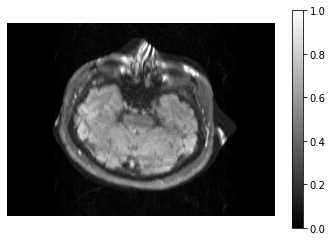

In [8]:
plotting_utils.plot_img_from_k(utils.join_reim_channels(tf.convert_to_tensor(a))[0,...])
plt.colorbar()

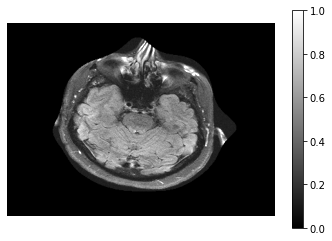

In [9]:
plotting_utils.plot_img(utils.join_reim_channels(tf.convert_to_tensor(b))[0,...])
plt.colorbar()

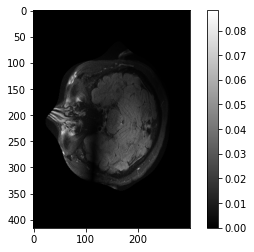

In [8]:
plt.figure()
plt.imshow(np.abs(utils.join_reim(b)[0,...]),cmap='gray')
plt.colorbar()

In [11]:
c = utils.convert_channels_to_image_domain(tf.convert_to_tensor(a))
c = np.sqrt(np.sum(np.square(np.abs(utils.join_reim_channels(c))),axis=3))
c = utils.split_reim(c)
c = np.fft.fftshift(c,axes=(1,2))

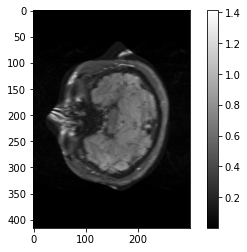

In [12]:
plt.figure()
plt.imshow(np.abs(utils.join_reim(c)[0,...]),cmap='gray')
plt.colorbar()

In [142]:
f = tf.cast(tf.convert_to_tensor(np.abs(utils.join_reim(c))),tf.float64)
g = tf.cast(tf.convert_to_tensor(np.fft.fftshift(np.abs(utils.join_reim(b)))),tf.float64)
print(tf.image.ssim(g,f,max_val=np.max(g), filter_size=7))

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: 3, 416, 300
7

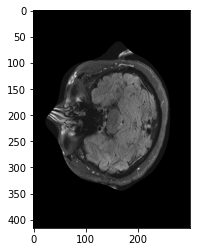

In [130]:
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(utils.join_reim(b)[0,...])),cmap='gray')

In [131]:
losses.multicoil_ssim('IMAGE_COILCOMBINED',44)(tf.convert_to_tensor(np.fft.fftshift(b,axes=(1,2))),c)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.7962281 , -0.8167095 , -0.64657956], dtype=float32)>